In [1]:
import math

# Fix the seed to get reproductible results
import numpy as np
np.random.seed(1)

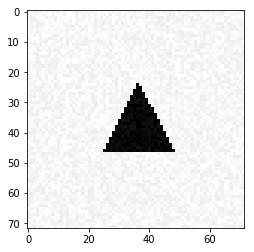

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




In [3]:
label_mapping = {
    0: 'rectangle',
    1: 'disk',
    2: 'triangle'
}

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
nb_epochs = 20
batch_size = 32

### 3 Simple Classification

###### Generating the dataset and one hot encode it

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


###### Train linear classifier with SGD optimizer

In [7]:
linear_model_sgd = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
linear_model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
linear_model_sgd.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 0s 406us/step - loss: 7.4018 - acc: 0.3700
Epoch 2/20
300/300 [==============================] - 0s 51us/step - loss: 11.0140 - acc: 0.3167
Epoch 3/20
300/300 [==============================] - 0s 48us/step - loss: 11.0140 - acc: 0.3167
Epoch 4/20
300/300 [==============================] - 0s 49us/step - loss: 11.0140 - acc: 0.3167
Epoch 5/20
300/300 [==============================] - 0s 49us/step - loss: 11.0140 - acc: 0.3167
Epoch 6/20
300/300 [==============================] - 0s 50us/step - loss: 11.0140 - acc: 0.3167
Epoch 7/20
300/300 [==============================] - 0s 50us/step - loss: 11.0140 - acc: 0.3167
Epoch 8/20
300/300 [==============================] - 0s 59us/step - loss: 11.0140 - acc: 0.3167
Epoch 9/20
300/300 [==============================] - 0s 67us/step - loss: 11.0140 - acc: 0.3167
Epoch 10/20
300/300 [==============================] - 0s 73us/step - loss: 11.0140 - acc: 0.3167
Epoch 11/20
300/300 [========

###### Train linear classifier with Adam optimizer

In [8]:
linear_model_adam = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
linear_model_adam.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
linear_model_adam.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 0s 566us/step - loss: 1.9376 - acc: 0.4133
Epoch 2/20
300/300 [==============================] - 0s 56us/step - loss: 0.9835 - acc: 0.5533
Epoch 3/20
300/300 [==============================] - 0s 53us/step - loss: 0.5822 - acc: 0.7700
Epoch 4/20
300/300 [==============================] - 0s 53us/step - loss: 0.5591 - acc: 0.7900
Epoch 5/20
300/300 [==============================] - 0s 53us/step - loss: 0.3579 - acc: 0.8300
Epoch 6/20
300/300 [==============================] - 0s 53us/step - loss: 0.3017 - acc: 0.8900
Epoch 7/20
300/300 [==============================] - 0s 55us/step - loss: 0.2584 - acc: 0.9067
Epoch 8/20
300/300 [==============================] - 0s 53us/step - loss: 0.2638 - acc: 0.8900
Epoch 9/20
300/300 [==============================] - 0s 53us/step - loss: 0.2171 - acc: 0.9433
Epoch 10/20
300/300 [==============================] - 0s 50us/step - loss: 0.2229 - acc: 0.9200
Epoch 11/20
300/300 [=================

After training the liner classifier with SGD and Adam we notice two things.

First the classifier with SGD does not converge at everyrun whereas the one with Adam does.

Second the classifier with Adam converge quicker than the one with SGD (when SGD converge)


### 4 Visualization of the Solution

In [9]:
from matplotlib import colors

In [10]:
weights = linear_model_adam.get_weights()
weight_max = max([np.max(arr) for arr in weights])
weight_min = min([np.min(arr) for arr in weights])

###### Weights plot

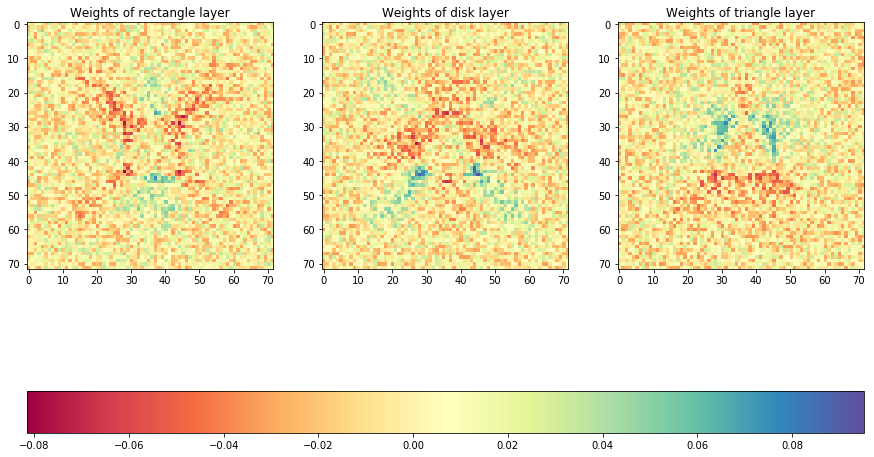

In [11]:
f, axarr = plt.subplots(1,3,figsize=(15, 15))

images = []
for i in range(3):
    images.append(axarr[i].imshow(linear_model_adam.get_weights()[0][:,i].reshape((IMAGE_SIZE,IMAGE_SIZE)), cmap='Spectral'))
    axarr[i].set_title(f'Weights of {label_mapping[i]} layer')
norm = colors.Normalize(vmin=weight_min, vmax=weight_max)
for im in images:
    im.set_norm(norm)
    
f.colorbar(images[0], ax=axarr, orientation='horizontal', fraction=.1)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())


for im in images:
    im.callbacksSM.connect('changed', update)

###### Plot in grayscale

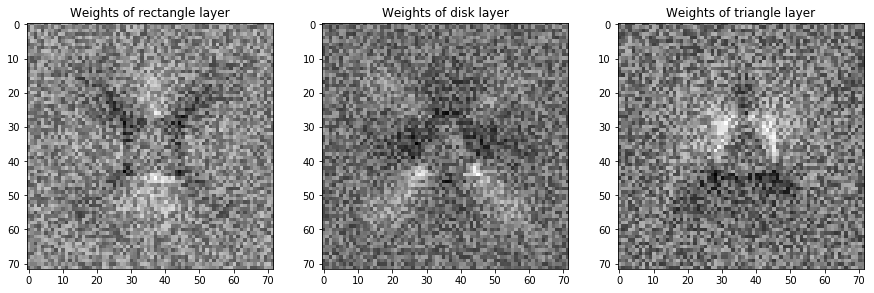

In [12]:
f, axarr = plt.subplots(1,3,figsize=(15, 15))
for i in range(3):
    images.append(axarr[i].imshow(linear_model_adam.get_weights()[0][:,i].reshape((IMAGE_SIZE,IMAGE_SIZE)), cmap='gray'))
    axarr[i].set_title(f'Weights of {label_mapping[i]} layer')

We can observe that it looks like a shape detector, in each image we can observe the shape it tries to detect a rectangle in the first one, a disk in the second and a triangle in the third. 

### 5 A More Difficult Classification Problem

As we noticed that Adam optimizer works better than SGD, we're gonna use Adam optimizer for the following

###### Generate test set

In [13]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


###### Generate bigger dataset as we're gonna need more data to have accurate result

In [14]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

###### Train linear model with 300 samples

In [15]:
linear_model_300_inputs = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
linear_model_300_inputs.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
linear_model_300_inputs.fit(X_train[:300], Y_train[:300], batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
300/300 [==============================] - 0s 628us/step - loss: 1.5393 - acc: 0.3567
Epoch 2/20
300/300 [==============================] - 0s 55us/step - loss: 1.0851 - acc: 0.4667
Epoch 3/20
300/300 [==============================] - 0s 53us/step - loss: 1.0281 - acc: 0.5200
Epoch 4/20
300/300 [==============================] - 0s 50us/step - loss: 0.9978 - acc: 0.5267
Epoch 5/20
300/300 [==============================] - 0s 53us/step - loss: 0.9312 - acc: 0.5667
Epoch 6/20
300/300 [==============================] - 0s 50us/step - loss: 0.9260 - acc: 0.5300
Epoch 7/20
300/300 [==============================] - 0s 51us/step - loss: 0.9108 - acc: 0.5567
Epoch 8/20
300/300 [==============================] - 0s 50us/step - loss: 0.8457 - acc: 0.5967
Epoch 9/20
300/300 [==============================] - 0s 52us/step - loss: 0.8480 - acc: 0.5933
Epoch 10/20
300/300 [==============================] - 0s 51us/step - loss: 0.8508 - acc: 0.6400
Epoch 11/20
300/300 [=================

In [16]:
linear_model_300_inputs.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 147us/step


[0.9827011855443318, 0.52]

Accuracy of the model is 52% for linear classifier and 300 samples 

###### Train linear model with 3000 samples

In [17]:
linear_model_3000_inputs = Sequential([
    Dense(3, activation='softmax',input_shape=X_train[0].shape)
])
linear_model_3000_inputs.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
linear_model_3000_inputs.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs)

Epoch 1/20
3000/3000 [==============================] - 0s 106us/step - loss: 1.2182 - acc: 0.4617
Epoch 2/20
3000/3000 [==============================] - 0s 46us/step - loss: 0.9435 - acc: 0.5470
Epoch 3/20
3000/3000 [==============================] - 0s 48us/step - loss: 0.9154 - acc: 0.5737
Epoch 4/20
3000/3000 [==============================] - 0s 46us/step - loss: 0.8712 - acc: 0.5680
Epoch 5/20
3000/3000 [==============================] - 0s 47us/step - loss: 0.8643 - acc: 0.5830
Epoch 6/20
3000/3000 [==============================] - 0s 46us/step - loss: 0.8343 - acc: 0.5987
Epoch 7/20
3000/3000 [==============================] - 0s 47us/step - loss: 0.9642 - acc: 0.5567
Epoch 8/20
3000/3000 [==============================] - 0s 47us/step - loss: 0.8421 - acc: 0.5887
Epoch 9/20
3000/3000 [==============================] - 0s 46us/step - loss: 0.8903 - acc: 0.5957
Epoch 10/20
3000/3000 [==============================] - 0s 46us/step - loss: 0.8489 - acc: 0.6000
Epoch 11/20
3000/3

In [18]:
linear_model_3000_inputs.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 171us/step


[0.9705325905481974, 0.526666667064031]

Accuracy of the model is 52.7% for linear classifier and 3000 samples which is quite similar to the one with 300 samples only +1%.

###### Train convolutional network with 300 samples

The convolutional network we're gonna use has
- One convolutional layer with 16 sublayer and a window of (5,5)
- One pooling layer (2,2)
- One flatten layer to be able to connect to one dense layer with 3 outputs (the ones we want to predict)

In [19]:
convolutional_model_300_inputs = Sequential()
convolutional_model_300_inputs.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
convolutional_model_300_inputs.add(MaxPooling2D(pool_size=(2, 2)))
convolutional_model_300_inputs.add(Flatten())
convolutional_model_300_inputs.add(Dense(3, activation='softmax'))

convolutional_model_300_inputs.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convolutional_model_300_inputs.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)[:300], Y_train[:300],
          batch_size=batch_size, epochs=nb_epochs, verbose=1)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 1.4840 - acc: 0.3400
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 1.0251 - acc: 0.4933
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.8347 - acc: 0.7400
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.7417 - acc: 0.8000
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.6558 - acc: 0.8233
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.5878 - acc: 0.8100
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.5397 - acc: 0.8500
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.4913 - acc: 0.8633
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.4688 - acc: 0.8267
Epoch 10/20
300/300 [==============================] - 0s 1ms/step - loss: 0.4217 - acc: 0.8700
Epoch 11/20
300/300 [============================

In [20]:
convolutional_model_300_inputs.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 0s 763us/step


[0.6943672752380371, 0.71]

Accuracy of the model is 71% for convolutionnal network and 300 samples, which is 20% more than what we had with linear classifier

###### convolutional network with 3000 samples

In [21]:
convolutional_model_3000_inputs = Sequential()
convolutional_model_3000_inputs.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
convolutional_model_3000_inputs.add(MaxPooling2D(pool_size=(2, 2)))
convolutional_model_3000_inputs.add(Flatten())
convolutional_model_3000_inputs.add(Dense(3, activation='softmax'))

convolutional_model_3000_inputs.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convolutional_model_3000_inputs.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_train,
          batch_size=batch_size, epochs=nb_epochs, verbose=1)

Epoch 1/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.8509 - acc: 0.6387
Epoch 2/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.5536 - acc: 0.8090
Epoch 3/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4494 - acc: 0.8470
Epoch 4/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3605 - acc: 0.8933
Epoch 5/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2953 - acc: 0.9160
Epoch 6/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2407 - acc: 0.9377
Epoch 7/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1968 - acc: 0.9513
Epoch 8/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1719 - acc: 0.9540
Epoch 9/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1427 - acc: 0.9647
Epoch 10/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1346 - acc: 0.9677
Epoch 11/20
3000/3000 [======

In [22]:
convolutional_model_3000_inputs.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 0s 903us/step


[0.15924152135848998, 0.946666665871938]

With 3000 samples, we had an accuracy of 94.7% for convolutional network which 23% more than which 300 samples

**Accuracy**


|Model                 | 300 inputs | 3000 inputs |
|----------------------|------------|-------------|
|Linear Classifier     |0.52        |0.52.7       |
|Convolutional Network |0.71        |0.94.7       |

To sump, adding data did not increase the accuracy for linear classifier. Convolutional network had an accuracy 20% higher than for linear classifier for 300 examples and if we use 3000 examples instead of 300 we had an accuracy 20% higher again. 
    We tried we two consecutives convolutional layers and did not observe any improvment.

###### Plot inputs that we we're not able to predict correctly

In [23]:
predictions = convolutional_model_3000_inputs.predict(X_test.reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1))


<Figure size 1800x4608 with 0 Axes>

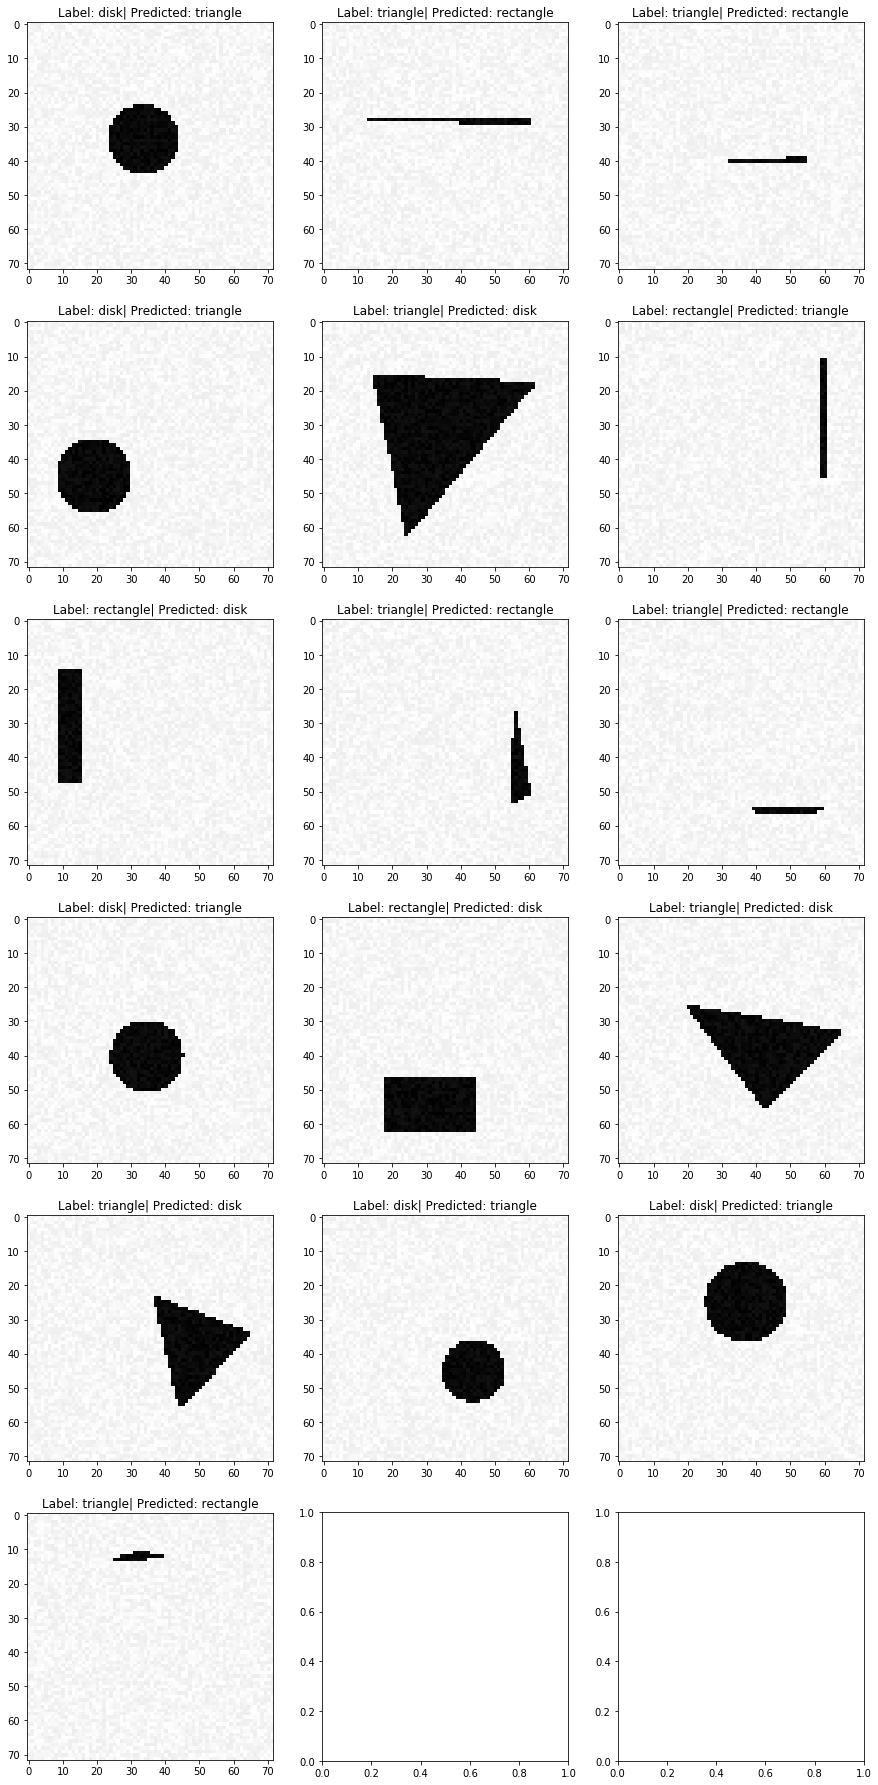

In [24]:
bad_predictions_mask = np.argmax(predictions , axis=1) != np.argmax(Y_test, axis=1)
X_bad_predicted = X_test[bad_predictions_mask]

predicted_labels = predictions[bad_predictions_mask]
real_labels = Y_test[bad_predictions_mask]

n_bad_prediction = X_bad_predicted.shape[0]

fig = plt.figure(figsize=(25, 4*n_bad_prediction))
fig, axarr = plt.subplots(int(math.ceil(n_bad_prediction/3)), 3, figsize=(15, 2*n_bad_prediction))
for i in range(n_bad_prediction):
    predicted_label = label_mapping[np.argmax(predicted_labels[i])]
    label = label_mapping[np.argmax(real_labels[i])]
    axarr[i//3][i%3].imshow(X_bad_predicted[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    title = f'Label: {label}| Predicted: {predicted_label}'
    axarr[i//3][i%3].set_title(title)


    We observe that a few images were not so easy to predict for humans too. 

### 6 A Regression Problem

###### Generate regression dataset

In [25]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


###### Sort points in order to have always the same output 

We need to somehow normalize the output because it has to be unique for each input which is not the case currently as we can do some permutation of the outputed points and the result would be the same. What we plan to do is sorting them by angles. We will compute the centroid of each triangle, centered their coordinates with the centroid and compute the angle with the horizontal axis, then we will order them by angles. The idea is to always have the same representation of the ouputs.

In [26]:
def sort_points(points):
    # Sort points of triangle by the angle between the point and the centroid and the abscisses axis
    points = points.reshape((3,2))
    centroid = np.sum(points, axis=0)/3
    centered_points = points - centroid
    angles = np.arctan2(centered_points[:,1], centered_points[:,0])
    # We need to add 2pi as the result is in [-pi, pi]
    angles = (angles + (angles < 0).astype('int') * 2* np.pi)/np.pi
    sorted_indexes = np.argsort(angles)
    return [points[sorted_indexes[0]], points[sorted_indexes[1]], points[sorted_indexes[2]]]

In [27]:
Y_train_sorted = np.apply_along_axis(sort_points, axis=1 ,arr=Y_train.reshape(-1,6))

###### Example of how do we sort points

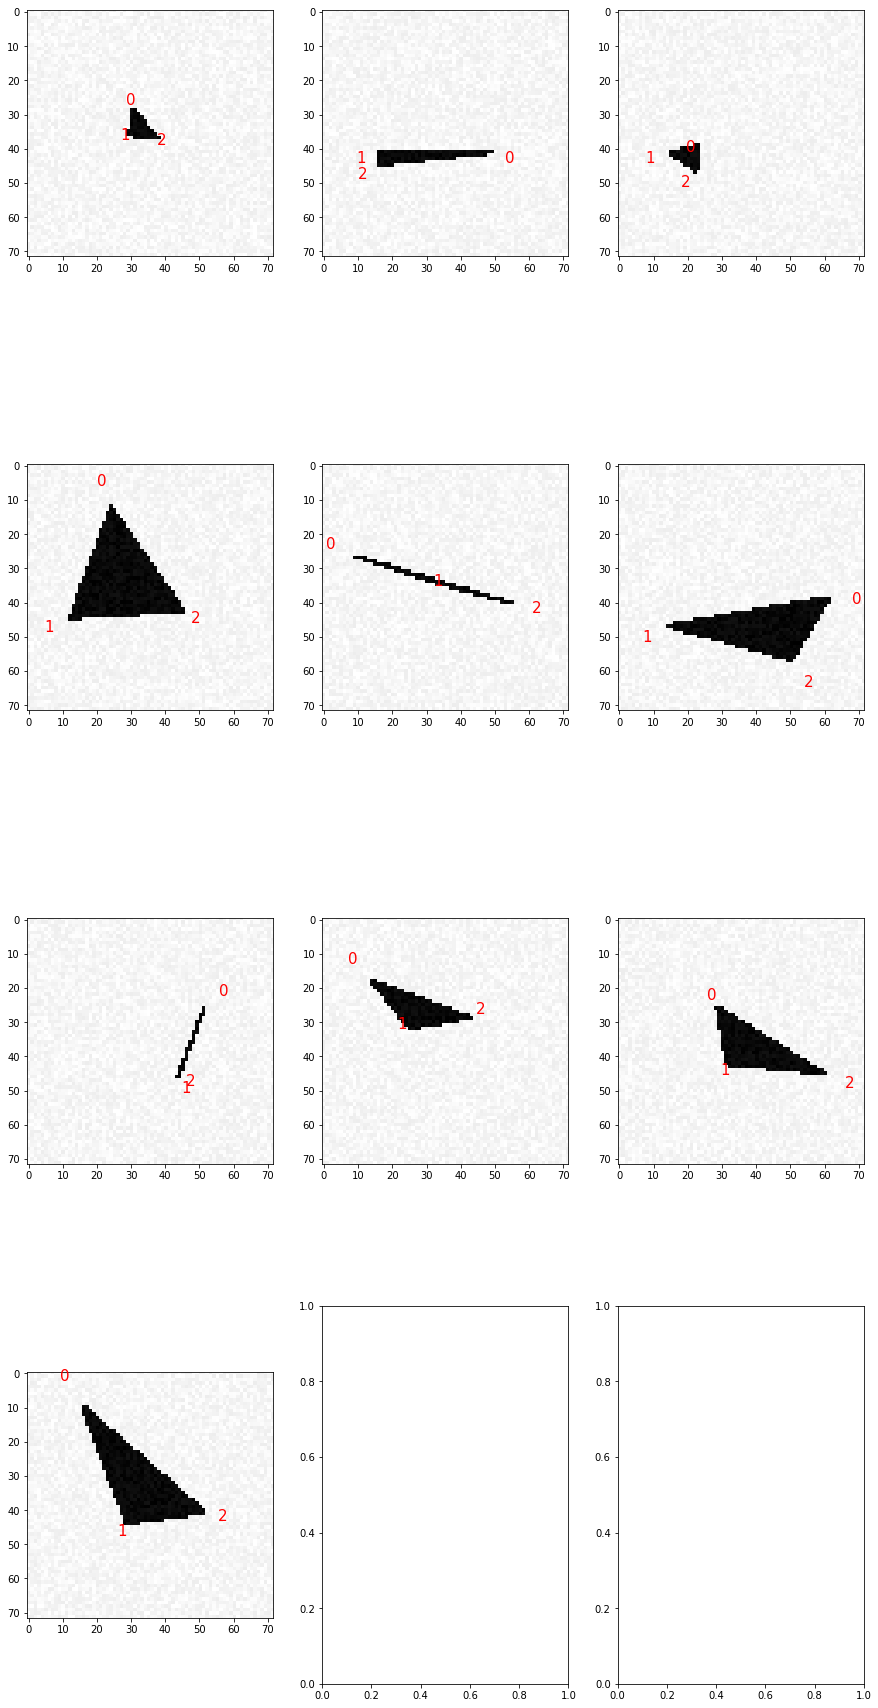

In [28]:
nb_to_display = 10
fig, axarr = plt.subplots(int(math.ceil(nb_to_display/3)), 3, figsize=(15, 2*n_bad_prediction))
for i in range(nb_to_display):
    axarr[i//3][i%3].imshow(X_train[i].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
    for j, point in enumerate(Y_train_sorted[i]):
        x, y = point*IMAGE_SIZE
        axarr[i//3][i%3].annotate(j,(x, IMAGE_SIZE-y), color='r',size=15)


In [29]:
X_test, Y_test = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [30]:
Y_test_sorted = np.apply_along_axis(sort_points, axis=1 ,arr=Y_test.reshape(-1,6))

In [31]:
regression_model = Sequential()
regression_model.add(Conv2D(64, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
regression_model.add(MaxPooling2D(pool_size=(2, 2)))
regression_model.add(Flatten())
regression_model.add(Dense(6))
regression_model.compile(optimizer='Adam', loss='mean_absolute_error')
regression_model.fit(X_train.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_train_sorted.reshape((-1,6)), epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 4ms/step - loss: 1.5543
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 0.3000
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2382
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1902
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1535
Epoch 6/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1253
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1056
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.0894
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.0836
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.0719
Epoch 11/20
300/300 [==============================] - 1s 4ms/step - loss: 0.0681
Epoch 12/20
300/300 [==============================] - 1s 4ms/step - loss: 0.0561
Epoch 13/20
300/300 [====

In [32]:
regression_model.evaluate(X_test.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1), Y_test.reshape((-1,6)))

300/300 [==============================] - 0s 1ms/step


0.24667792320251464

The mean absolute average is quite high, the problem probably comes from the way we normalized outputs, it's porabably not enough normalized

### 7 Image Denoising

#### Random noise generated with a gaussian

   We're gonna generate noise with a gaussian, let's have a look on the variance we should use

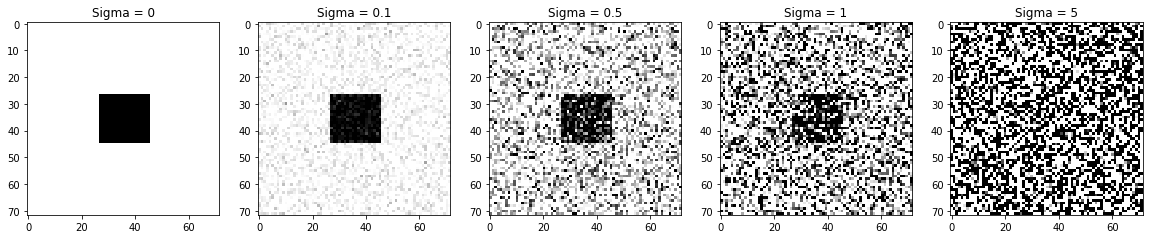

In [33]:
image = generate_a_rectangle()/255

sigmas = [0, 0.1, 0.5, 1, 5]
fig, axarr = plt.subplots(1,len(sigmas), figsize=(20,5))
for i, sigma in enumerate(sigmas):
    image_with_noise = np.clip(image + np.random.normal(loc=0, scale=sigma, size=(1,IMAGE_SIZE*IMAGE_SIZE)), 0,1)
    axarr[i].imshow(image_with_noise.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
    axarr[i].set_title(f'Sigma = {sigma}')

    Let's continue with sigma = 0.5

###### Creating a function to generate the dataset with and without noise

In [34]:
def generate_noisy_dataset(nb_samples, noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(0, free_location)
        else:
            [X[i], V] = generate_a_triangle(0, free_location)
    X = X/255
    noisy_X = np.clip(X + np.random.normal(loc=0, scale=noise, size=(nb_samples,IMAGE_SIZE*IMAGE_SIZE)), 0,1)
    return [noisy_X, X]

X_train, Y_train = generate_noisy_dataset(300, 0.5, True)


Creating data:


### Sample of images generated

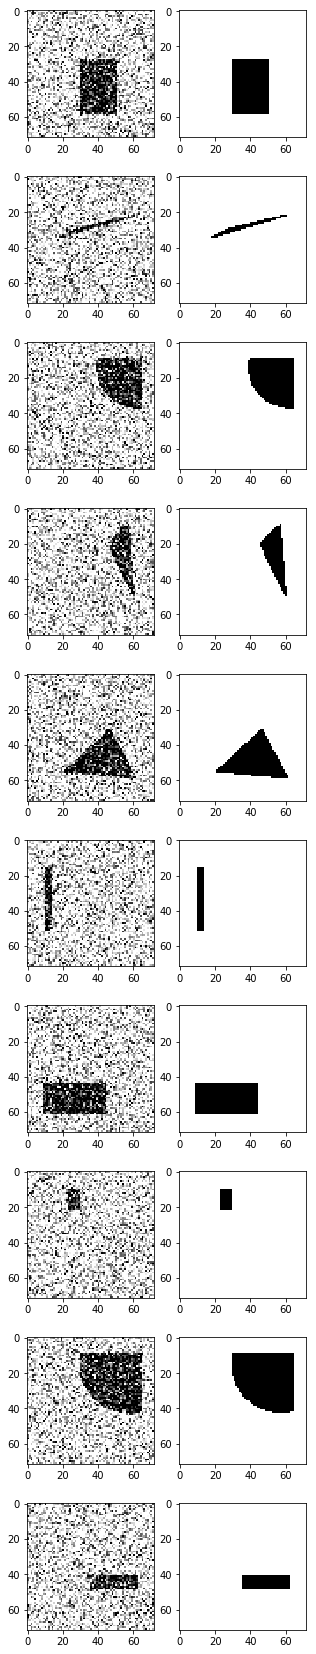

In [35]:
nb_to_display = 10
fig, axarr = plt.subplots(nb_to_display, 2, figsize=(5, 3*nb_to_display))
for i in range(nb_to_display):
    axarr[i][0].imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    axarr[i][1].imshow(Y_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

###### We're gonna use a unet network to denoise our dataset

In [36]:
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *


def unet():
    input_size = (256,256, 1)
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 5e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


As we use consecutive pooling of a factor 2 we need to have an image size of 256 or 128, otherwise we will end up with issues on merging layer as the to layer we would want to merge would not necessarily be of the same shape

In [37]:
X_train_resized = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=X_train)
Y_train_resized = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=Y_train)

/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [38]:
model_unet = unet()

/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


###### It took 15 minutes to train the model.

In [39]:
X_train, Y_train = generate_noisy_dataset(300, 0.5, True)
X_train_resized = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=X_train)
Y_train_resized = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=Y_train)

Creating data:


In [40]:
model_unet.fit(X_train_resized.reshape((-1, 256, 256, 1)), Y_train_resized.reshape((-1, 256, 256, 1)),batch_size=1, epochs=1, verbose=1)
#model_unet.save('denoising_hourglass.h5')


In [41]:
X_test, Y_test = generate_noisy_dataset(300, 0.5, True)
X_test = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=X_test)
Y_test = np.apply_along_axis(lambda x: trans.resize(x.reshape(IMAGE_SIZE, IMAGE_SIZE), (256, 256)), axis=1, arr=Y_test)


Creating data:


In [42]:
Y_pred = model_unet.predict(X_test.reshape((-1,256,256,1)))

###### Some ouputs of the model

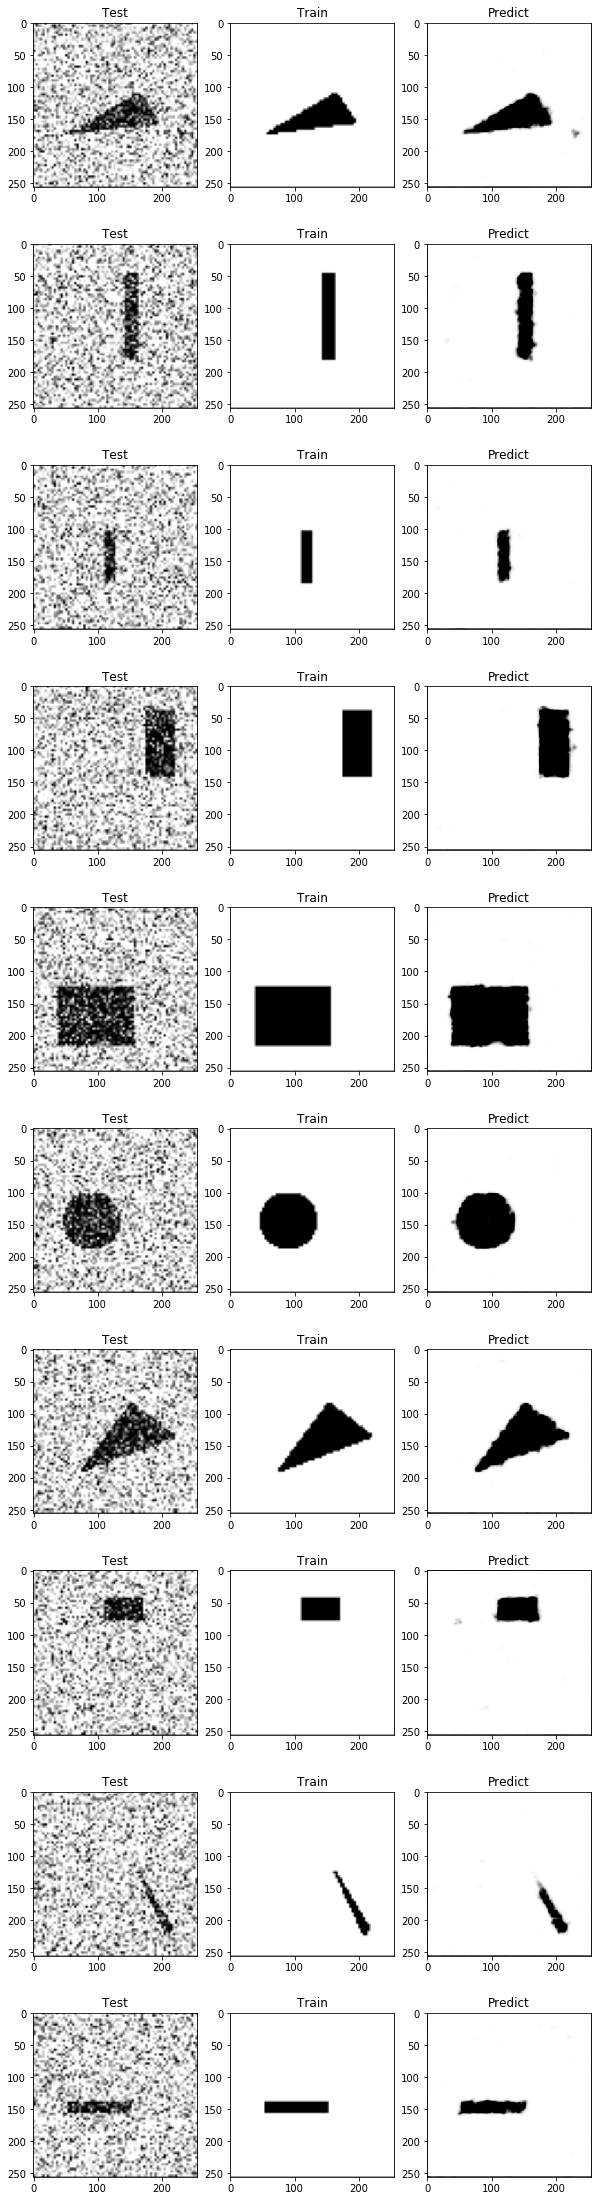

In [43]:
nb_to_display = 10
fig, axarr = plt.subplots(nb_to_display, 3, figsize=(10, 4*nb_to_display))
for i in range(nb_to_display):
    axarr[i][0].imshow(X_test[i].reshape(256,256), cmap='gray')
    axarr[i][0].set_title('Test')
    axarr[i][1].imshow(Y_test[i].reshape(256,256), cmap='gray')
    axarr[i][1].set_title('Train')
    axarr[i][2].imshow(Y_pred[i].reshape(256,256), cmap='gray')
    axarr[i][2].set_title('Predict')

As we can see the model is a good denoiser

In [44]:
model_unet.evaluate(X_test.reshape((-1,256,256,1)),Y_test.reshape((-1,256,256,1)))

300/300 [==============================] - 319s 1s/step


[0.0806565476457278, 0.9484461466471354]

Model has an accuracy of 94.8% which is quite good.